# Link prediction example: GraphSAGE on GOV.UK data

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification, \
                                MeanPoolingAggregator, AttentionalAggregator, MaxPoolingAggregator

import keras 
from stellargraph import globalvar
import numpy as np
from datetime import datetime

Using TensorFlow backend.


### Load the GOV.UK network data

In [2]:
DATA_DIR = os.getenv("DATA_DIR")
MODELS_DIR = os.getenv("MODELS_DIR")
content_api = os.path.join(DATA_DIR, "content_api")
edgefile = os.path.join(DATA_DIR, "processed_network", "edges_graphsagetest_feb_01_18_doo_min15weight_wtext.csv.gz")
embeddings_file = os.path.join(content_api, "training_node_data_fixd.csv.gz")

Load the graph from edgelist

In [3]:
edgelist = pd.read_csv(edgefile, compression="gzip")
edgelist["label"] = "go_to"  

In [4]:
edgelist

,src_node,dest_node,weight,src_cid,dest_cid,source,target,label
0,/government/publications/guidance-for-dependan...,/visa-fees,66,5ef7560d-7631-11e4-a3cb-005056011aef,1e333395-5dd5-4452-96a3-fbe939928761,33265,58314,go_to
1,/visa-fees,/find-a-visa-application-centre,1164,1e333395-5dd5-4452-96a3-fbe939928761,aa055bd6-fde1-4471-8ac2-ac86241b4898,58314,12343,go_to
2,/entering-staying-uk/family-visas,/uk-family-visa,377,d612c61e-22f4-4922-8bb2-b04b9202126e,305acc88-488e-44ec-8e5a-1a5de7819ba9,23720,25053,go_to
3,/uk-family-visa,/uk-family-visa/partner-spouse,26227,305acc88-488e-44ec-8e5a-1a5de7819ba9,305acc88-488e-44ec-8e5a-1a5de7819ba9,25053,14044,go_to
4,/uk-family-visa/partner-spouse,/government/publications/application-for-uk-vi...,2733,305acc88-488e-44ec-8e5a-1a5de7819ba9,5ef421be-7631-11e4-a3cb-005056011aef,14044,33797,go_to
5,/government/publications/application-for-uk-vi...,/uk-family-visa/provide-information,116,5ef421be-7631-11e4-a3cb-005056011aef,305acc88-488e-44ec-8e5a-1a5de7819ba9,33797,29781,go_to
6,/uk-family-visa/provide-information,/apply-to-come-to-the-uk,32,305acc88-488e-44ec-8e5a-1a5de7819ba9,76698ffe-70ab-4fda-be0d-755234f6d340,29781,24233,go_to
7,/apply-to-come-to-the-uk,/apply-to-come-to-the-uk/prepare-your-application,43994,76698ffe-70ab-4fda-be0d-755234f6d340,76698ffe-70ab-4fda-be0d-755234f6d340,24233,20546,go_to
8,/apply-to-come-to-the-uk/prepare-your-application,/visa-processing-times,4669,76698ffe-70ab-4fda-be0d-755234f6d340,72ed754c-4c82-415f-914a-ab6760454cb4,20546,31442,go_to
9,/visa-processing-times,/apply-to-come-to-the-uk/prepare-your-application,1220,72ed754c-4c82-415f-914a-ab6760454cb4,76698ffe-70ab-4fda-be0d-755234f6d340,31442,20546,go_to


### Load the features and subject for the nodes

In [7]:
node_data = pd.read_csv(embeddings_file, compression="gzip", index_col=0)

In [8]:
node_data.loc[25053].content_id

'305acc88-488e-44ec-8e5a-1a5de7819ba9'

In [11]:
node_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,content_id
0,0.014993,0.024639,0.058578,0.008009,0.008096,-0.062776,0.059777,0.005778,-0.008614,0.059473,...,0.065568,0.044270,-0.046852,0.035862,-0.043941,0.009524,-0.037714,-0.001525,-0.063660,80f7a69c-5cdc-4bd5-a16c-15d669ba2cc5
1,-0.057149,0.025875,0.049524,0.024483,-0.007833,-0.035528,0.056479,0.009408,-0.044370,-0.040844,...,0.056229,0.056662,-0.038329,0.056141,-0.052406,-0.038637,-0.047737,0.046157,-0.054258,81fb4151-bc2b-49b1-b86e-22f2a1d14208


In [12]:
node_data.shape

(66619, 513)

Define a set of node features that will be used by the model as the difference between the set of all node features and a list of user-defined node attributes to ignore:

In [13]:
# ignore_attr = []
# feature_names = sorted(set(column_names) - set(ignore_attr))
feature_names = node_data.columns[:-1]
feature_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=512)

We need to convert node features that will be used by the model to numeric values that are required for GraphSAGE input. Note that all node features in the Cora dataset, except the categorical "subject" feature, are already numeric, and don't require the conversion.

In [14]:
if "subject" in feature_names:
    # Convert node features to numeric vectors
    feature_encoding = feature_extraction.DictVectorizer(sparse=False)
    node_features = feature_encoding.fit_transform(
        node_data[feature_names].to_dict("records")
    )
else:  # node features are already numeric, no further conversion is needed
    node_features = node_data[feature_names].values

### Set up graph from edgelist

In [15]:
G = nx.from_pandas_edgelist(edgelist[['source','target','label']], edge_attr="label")
type(G)

networkx.classes.graph.Graph

Add node data to G:

In [16]:
for nid, f in zip(node_data.index, node_features):
    if nid in G.node.keys():
        G.node[nid][globalvar.TYPE_ATTR_NAME] = "page"  # specify node type
        G.node[nid]["feature"] = f
    else:
        print("missing",nid)

From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Repeat this procedure to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges and the reduced graph G_train with the positive train edges removed:

In [17]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G)
# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(p=0.1, 
                                                                                  method="global",
                                                                                  keep_connected=True)

Removed 1000 edges
Removed 2000 edges
Removed 3000 edges
Removed 4000 edges
Removed 5000 edges
Removed 6000 edges
Removed 7000 edges
Removed 8000 edges
Removed 9000 edges
Removed 10000 edges
Removed 11000 edges
Removed 12000 edges
Removed 13000 edges
Removed 14000 edges
Sampled 1000 negative examples
Sampled 2000 negative examples
Sampled 3000 negative examples
Sampled 4000 negative examples
Sampled 5000 negative examples
Sampled 6000 negative examples
Sampled 7000 negative examples
Sampled 8000 negative examples
Sampled 9000 negative examples
Sampled 10000 negative examples
Sampled 11000 negative examples
Sampled 12000 negative examples
Sampled 13000 negative examples
Sampled 14000 negative examples
** Sampled 14625 positive and 14625 negative edges. **


In [18]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G_train)
# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(p=0.1, 
                                                                              method="global", 
                                                                              keep_connected=True)

Removed 1000 edges
Removed 2000 edges
Removed 3000 edges
Removed 4000 edges
Removed 5000 edges
Removed 6000 edges
Removed 7000 edges
Removed 8000 edges
Removed 9000 edges
Removed 10000 edges
Removed 11000 edges
Removed 12000 edges
Removed 13000 edges
Sampled 1000 negative examples
Sampled 2000 negative examples
Sampled 3000 negative examples
Sampled 4000 negative examples
Sampled 5000 negative examples
Sampled 6000 negative examples
Sampled 7000 negative examples
Sampled 8000 negative examples
Sampled 9000 negative examples
Sampled 10000 negative examples
Sampled 11000 negative examples
Sampled 12000 negative examples
Sampled 13000 negative examples
** Sampled 13162 positive and 13162 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Convert G_train and G_test to StellarGraph objects (undirected, as required by GraphSAGE) for ML:

In [19]:
G_train = sg.StellarGraph(G_train, node_features="feature")
G_test = sg.StellarGraph(G_test, node_features="feature")

Summary of G_train and G_test - note that they have the same set of nodes, only differing in their edge sets:

In [20]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 66619, Edges: 131629

 Node types:
  page: [66619]
        Attributes: {'feature'}
    Edge types: page-go_to->page

 Edge types:
    page-go_to->page: [131629]



In [21]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 66619, Edges: 118467

 Node types:
  page: [66619]
        Attributes: {'feature'}
    Edge types: page-go_to->page

 Edge types:
    page-go_to->page: [118467]



Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes `(paper1, paper2)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(paper1, paper2)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

### Model parameters

In [22]:
batch_size = 25
epochs = 20

In [23]:
# Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:
# Length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model
num_samples = [10, 5]

In [24]:
layer_sizes = [20, 20]
assert len(layer_sizes) == len(num_samples)

### Set up train and test set data generators

In [25]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples).flow(edge_ids_train, 
                                                                          edge_labels_train, 
                                                                          shuffle=True)
test_gen = GraphSAGELinkGenerator(G_test,  batch_size, num_samples).flow(edge_ids_test, 
                                                                         edge_labels_test)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated `(paper1, paper2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [26]:
graphsage = GraphSAGE(layer_sizes=layer_sizes, 
                      generator=train_gen, 
                      bias=True, 
                      dropout=0.1, 
                      aggregator=MaxPoolingAggregator)

In [27]:
# Expose input and output sockets of graphsage, for source and destination nodes:
x_inp_src, x_out_src = graphsage.default_model(flatten_output=False)
x_inp_dst, x_out_dst = graphsage.default_model(flatten_output=False)
# re-pack into a list where (source, destination) inputs alternate, for link inputs:
x_inp = [x for ab in zip(x_inp_src, x_inp_dst) for x in ab]
# same for outputs:
x_out = [x_out_src, x_out_dst]

Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

### Set up `link_classification` layer and model

In [28]:
prediction = link_classification(output_dim=1, output_act="relu", edge_embedding_method='ip')(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [32]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

Evaluate the initial (untrained) model on the train and test set:

In [33]:
init_train_metrics = model.evaluate_generator(train_gen, verbose=1)
init_test_metrics = model.evaluate_generator(test_gen, verbose=1)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1053/1053 [==============================] - 15s 14ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 2.3363
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 2.3385
	binary_accuracy: 0.5000


In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10, 512)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 50, 512)      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 10, 512)      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 50, 512)      0                                            
__________________________________________________________________________________________________
input_1 (I

### Train the model

In [35]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=1,
        shuffle=True,
    )

Epoch 1/20
1170/1170 [==============================] - 45s 38ms/step - loss: 0.4533 - binary_accuracy: 0.8003 - val_loss: 0.3796 - val_binary_accuracy: 0.8709
Epoch 2/20
1170/1170 [==============================] - 44s 38ms/step - loss: 0.3067 - binary_accuracy: 0.8823 - val_loss: 0.3216 - val_binary_accuracy: 0.8919
Epoch 3/20
1170/1170 [==============================] - 44s 38ms/step - loss: 0.2638 - binary_accuracy: 0.9069 - val_loss: 0.2868 - val_binary_accuracy: 0.9144
Epoch 4/20
1170/1170 [==============================] - 44s 38ms/step - loss: 0.2292 - binary_accuracy: 0.9169 - val_loss: 0.2885 - val_binary_accuracy: 0.9151
Epoch 5/20
1170/1170 [==============================] - 45s 38ms/step - loss: 0.2341 - binary_accuracy: 0.9161 - val_loss: 0.2709 - val_binary_accuracy: 0.9202
Epoch 6/20
1170/1170 [==============================] - 46s 39ms/step - loss: 0.2141 - binary_accuracy: 0.9277 - val_loss: 0.2703 - val_binary_accuracy: 0.9269
Epoch 7/20
1170/1170 [==================

In [36]:
filename = "{}_b{}_ns{}-{}_l{}-{}_e{}_{}".format(MaxPoolingAggregator.__name__,
                                                    batch_size, 
                                                    num_samples[0], num_samples[1], 
                                                    layer_sizes[0],layer_sizes[0],
                                                    epochs,
                                                    datetime.now().strftime("%d%m%y"))+".h5"
filename

'MaxPoolingAggregator_b25_ns10-5_l20-20_e20_220219.h5'

In [37]:
model.save(os.path.join(MODELS_DIR, filename))

### Plot metrics
Plot the training history:

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    
    f,axs = plt.subplots(1, len(metrics), figsize=(12,4))

    for m,ax in zip(metrics,axs):
        # summarize history for metric m
        ax.plot(history.history[m])
        ax.plot(history.history['val_' + m])
        ax.set_title(m)
        ax.set_ylabel(m)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper right')

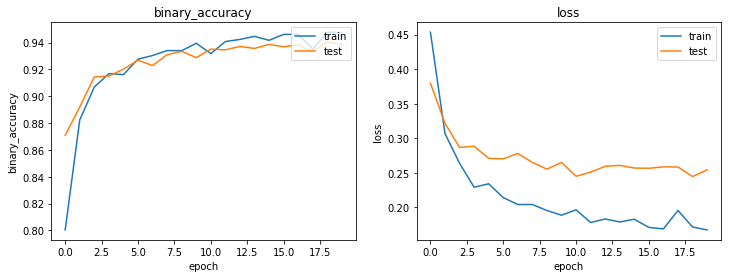

In [39]:
plot_history(history)

Evaluate the trained model on test citation links:

In [40]:
train_metrics = model.evaluate_generator(train_gen, verbose=1)
test_metrics = model.evaluate_generator(test_gen, verbose=1)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1053/1053 [==============================] - 15s 14ms/step

Train Set Metrics of the trained model:
	loss: 0.2203
	binary_accuracy: 0.9513

Test Set Metrics of the trained model:
	loss: 0.2550
	binary_accuracy: 0.9399
